In [16]:
# ============================================
# Contexto local de entorno de programación
# ============================================
import os
import pandas as pd
import numpy as np

DATA_DIR        = r'D:\repos\cannibalization_reatail\.data'

def read_csv_safe(path, **kwargs):
    full_path = os.path.join(DATA_DIR, path)
    return pd.read_csv(full_path, **kwargs)

ventas = read_csv_safe(
    'train.csv',
    usecols=["date","store_nbr","item_nbr","unit_sales","onpromotion"],
    parse_dates=["date"]
)
items = read_csv_safe(
    'items.csv',
    usecols=["item_nbr","family","class","perishable"]
)
stores = read_csv_safe(
    'stores.csv'
)
hol = read_csv_safe('holidays_events.csv', parse_dates=["date"])
hol = hol[hol["transferred"]==False].copy()
hol["week_start"] = hol["date"] - pd.to_timedelta(hol["date"].dt.weekday, unit="D")

# National → cross-join con todas las tiendas
hol_nat = hol[hol["locale"]=="National"].assign(key=1).merge(stores[['store_nbr']].assign(key=1), on="key").drop(columns="key")

# Regional → join por estado
hol_reg = hol[hol["locale"]=="Regional"].merge(stores[['state','store_nbr']], left_on="locale_name", right_on="state", how="left")

# Local → join por ciudad
hol_loc = hol[hol["locale"]=="Local"].merge(stores[['city','store_nbr']], left_on="locale_name", right_on="city", how="left")

eq_date = pd.to_datetime("2016-04-16")
trans = read_csv_safe('transactions.csv', parse_dates=["date"])
oil = read_csv_safe('oil.csv', parse_dates=["date"])

# ============================================
# 4.1. Construcción de variables clave y controles
# ============================================

# -----------------------
# Parámetros del capítulo
# -----------------------
THETA_DIAS_PROMO_SEMANA = 2/7   # θ: exige al menos 2 días de promo en la semana
FOURIER_K = 2                   # Nº de armónicos anuales (52 semanas aprox.)
LAGS = [1, 2, 4, 8]             # Lags semanales de la variable dependiente

# -----------------------
# Utilidades comunes
# -----------------------
def add_week_start(df, date_col="date", out_col="week_start"):
    df[out_col] = df[date_col] - pd.to_timedelta(df[date_col].dt.weekday, unit="D")
    return df

def safe_bool_to_int(s):
    # Convierte {True/False, "True"/"False", 1/0, NaN} → {1,0}
    if s.dtype == bool:
        return s.astype("int8")
    if pd.api.types.is_numeric_dtype(s):
        return s.fillna(0).astype("int8").clip(0,1)
    # objeto/cadena
    return s.fillna(False).astype(str).str.lower().isin(["true","1","t","yes"]).astype("int8")

# -----------------------
# Agregación a nivel semanal: Y_{isw}, δ_{isw}, ˜P_{isw}
# -----------------------
# Tipos eficientes
ventas["store_nbr"] = ventas["store_nbr"].astype("int32")
ventas["item_nbr"]  = ventas["item_nbr"].astype("int32")
ventas["unit_sales"] = pd.to_numeric(ventas["unit_sales"], errors="coerce").astype("float32")

# onpromotion → {0,1}
ventas["onpromotion"] = safe_bool_to_int(ventas["onpromotion"])

# Semana ISO: lunes como inicio (coherente con 'hol')
ventas = add_week_start(ventas, "date", "week_start")

# Agregación semanal por (tienda, ítem, semana)
agg_week = (
    ventas
    .groupby(["store_nbr","item_nbr","week_start"], as_index=False)
    .agg(
        Y_isw = ("unit_sales", "sum"),               # Y_{isw} = ∑_t Y_{ist}
        dias_semana = ("date", "nunique"),           # |ι(w)|
        promo_dias = ("onpromotion", "sum")          # ∑_t P_{ist}
    )
)

# δ_{isw} = (días en promo) / |ι(w)| ; ˜P_{isw} = I(δ_{isw} ≥ θ)
agg_week["delta_isw"] = (agg_week["promo_dias"] / agg_week["dias_semana"]).astype("float32")
agg_week["Ptilde_isw"] = (agg_week["delta_isw"] >= THETA_DIAS_PROMO_SEMANA).astype("int8")

# Transformación logarítmica opcional de la variable dependiente
agg_week["y_isw"] = np.log1p(agg_week["Y_isw"]).astype("float32")

# -----------------------
# Controles: metadatos de ítems y tiendas
# -----------------------
items["item_nbr"] = items["item_nbr"].astype("int32")
items["perishable"] = items["perishable"].astype("int8")
stores["store_nbr"] = stores["store_nbr"].astype("int32")

panel = (
    agg_week
    .merge(items, on="item_nbr", how="left")
    .merge(stores, on="store_nbr", how="left")
)


# -----------------------
# Control de tráfico: transacciones por tienda-semana (F_{sw})
# -----------------------
trans = add_week_start(trans, "date", "week_start")
trans["store_nbr"] = trans["store_nbr"].astype("int32")
trans_week = (
    trans
    .groupby(["store_nbr","week_start"], as_index=False)
    .agg(F_sw=("transactions","sum"))
)
trans_week["log_F_sw"] = np.log1p(trans_week["F_sw"]).astype("float32")

panel = panel.merge(trans_week, on=["store_nbr","week_start"], how="left")

# -----------------------
# Control macro: petróleo promedio semanal (O_w) con forward fill
# -----------------------
# Kaggle: columna suele llamarse 'dcoilwtico'
oil = oil.sort_values("date").copy()
oil["dcoilwtico"] = pd.to_numeric(oil["dcoilwtico"], errors="coerce")
oil["dcoilwtico"] = oil["dcoilwtico"].ffill()
oil = add_week_start(oil, "date", "week_start")
oil_week = (
    oil
    .groupby("week_start", as_index=False)
    .agg(O_w=("dcoilwtico","mean"))
)
oil_week["O_w"] = oil_week["O_w"].astype("float32")

panel = panel.merge(oil_week, on="week_start", how="left")

# -----------------------
# Choque macro-institucional puntual: terremoto 2016-04-16 (semana del evento)
# -----------------------
eq_week = eq_date - pd.to_timedelta(eq_date.weekday(), unit="D")
panel["eq_shock"] = (panel["week_start"] == eq_week).astype("int8")

# -----------------------
# Estacionalidad anual suave: términos de Fourier (K armónicos)
# -----------------------
# Índice semanal global w = 0,1,... con base en fechas únicas de 'week_start'
weeks_sorted = np.sort(panel["week_start"].unique())
week_to_index = {w:i for i, w in enumerate(weeks_sorted)}
panel["w_idx"] = panel["week_start"].map(week_to_index).astype("int32")

for k in range(1, FOURIER_K+1):
    panel[f"fourier_s{k}"] = np.sin(2*np.pi*k*panel["w_idx"]/52).astype("float32")
    panel[f"fourier_c{k}"] = np.cos(2*np.pi*k*panel["w_idx"]/52).astype("float32")


# -----------------------
# Dinámica temporal: lags semanales de y_{isw}
# -----------------------
panel = panel.sort_values(["store_nbr","item_nbr","week_start"])
for L in LAGS:
    panel[f"lag{L}"] = (
        panel.groupby(["store_nbr","item_nbr"], sort=False)["y_isw"].shift(L)
    ).astype("float32")

# -----------------------
# Tipos finales y columnas organizadas
# -----------------------
# Variables clave del capítulo: Y_{isw}, y_{isw}, δ_{isw}, ˜P_{isw}
# Controles X_{isw}: H_*, log_F_sw, O_w, lags, Fourier, metadatos de tienda/ítem, eq_shock
cols_order = [
    "store_nbr","item_nbr","week_start",
    "Y_isw","y_isw","dias_semana","promo_dias","delta_isw","Ptilde_isw",
    "family","class","perishable","city","state","type","cluster",
    "F_sw","log_F_sw","O_w","H_nat","H_reg","H_loc","eq_shock",
    "w_idx"
] + [f"fourier_s{k}" for k in range(1, FOURIER_K+1)] \
  + [f"fourier_c{k}" for k in range(1, FOURIER_K+1)] \
  + [f"lag{L}" for L in LAGS]

# Asegurar existencia de todas las columnas (algunas pueden faltar si merges no matchean)
for c in cols_order:
    if c not in panel.columns:
        panel[c] = np.nan

panel = panel[cols_order].reset_index(drop=True)



C:\Users\PC\AppData\Local\Temp\ipykernel_11804\1505337438.py:12: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(full_path, **kwargs)
C:\Users\PC\AppData\Local\Temp\ipykernel_11804\1505337438.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return s.fillna(False).astype(str).str.lower().isin(["true","1","t","yes"]).astype("int8")
c:\Users\PC\Miniconda3\envs\causal_ml\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PC\Miniconda3\envs\causal_ml\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, 

In [18]:
panel.to_csv('panel.csv', index=False)

In [1]:
# ============================================
# Contexto local de entorno de programación
# ============================================
import os
import pandas as pd
import numpy as np

DATA_DIR        = r'D:\repos\cannibalization_reatail\.data'

def read_csv_safe(path, **kwargs):
    full_path = os.path.join(DATA_DIR, path)
    return pd.read_csv(full_path, **kwargs)

ventas = read_csv_safe(
    'train.csv',
    usecols=["date","store_nbr","item_nbr","unit_sales","onpromotion"],
    parse_dates=["date"]
)
items = read_csv_safe(
    'items.csv',
    usecols=["item_nbr","family","class","perishable"]
)
stores = read_csv_safe(
    'stores.csv'
)
hol = read_csv_safe('holidays_events.csv', parse_dates=["date"])
hol = hol[hol["transferred"]==False].copy()
hol["week_start"] = hol["date"] - pd.to_timedelta(hol["date"].dt.weekday, unit="D")

# National → cross-join con todas las tiendas
hol_nat = hol[hol["locale"]=="National"].assign(key=1).merge(stores[['store_nbr']].assign(key=1), on="key").drop(columns="key")

# Regional → join por estado
hol_reg = hol[hol["locale"]=="Regional"].merge(stores[['state','store_nbr']], left_on="locale_name", right_on="state", how="left")

# Local → join por ciudad
hol_loc = hol[hol["locale"]=="Local"].merge(stores[['city','store_nbr']], left_on="locale_name", right_on="city", how="left")

eq_date = pd.to_datetime("2016-04-16")
trans = read_csv_safe('transactions.csv', parse_dates=["date"])
oil = read_csv_safe('oil.csv', parse_dates=["date"])

# ============================================
# 4.1. Construcción de variables clave y controles
# ============================================

# -----------------------
# Parámetros del capítulo
# -----------------------
THETA_DIAS_PROMO_SEMANA = 2/7   # θ: exige al menos 2 días de promo en la semana
FOURIER_K = 2                   # Nº de armónicos anuales (52 semanas aprox.)
LAGS = [1, 2, 4, 8]             # Lags semanales de la variable dependiente

# -----------------------
# Utilidades comunes
# -----------------------
def add_week_start(df, date_col="date", out_col="week_start"):
    df[out_col] = df[date_col] - pd.to_timedelta(df[date_col].dt.weekday, unit="D")
    return df

def safe_bool_to_int(s):
    # Convierte {True/False, "True"/"False", 1/0, NaN} → {1,0}
    if s.dtype == bool:
        return s.astype("int8")
    if pd.api.types.is_numeric_dtype(s):
        return s.fillna(0).astype("int8").clip(0,1)
    # objeto/cadena
    return s.fillna(False).astype(str).str.lower().isin(["true","1","t","yes"]).astype("int8")

# -----------------------
# Agregación a nivel semanal: Y_{isw}, δ_{isw}, ˜P_{isw}
# -----------------------
# Tipos eficientes
ventas["store_nbr"] = ventas["store_nbr"].astype("int32")
ventas["item_nbr"]  = ventas["item_nbr"].astype("int32")
ventas["unit_sales"] = pd.to_numeric(ventas["unit_sales"], errors="coerce").astype("float32")

# onpromotion → {0,1}
ventas["onpromotion"] = safe_bool_to_int(ventas["onpromotion"])

# Semana ISO: lunes como inicio (coherente con 'hol')
ventas = add_week_start(ventas, "date", "week_start")

# Agregación semanal por (tienda, ítem, semana)
agg_week = (
    ventas
    .groupby(["store_nbr","item_nbr","week_start"], as_index=False)
    .agg(
        Y_isw = ("unit_sales", "sum"),               # Y_{isw} = ∑_t Y_{ist}
        dias_semana = ("date", "nunique"),           # |ι(w)|
        promo_dias = ("onpromotion", "sum")          # ∑_t P_{ist}
    )
)

# δ_{isw} = (días en promo) / |ι(w)| ; ˜P_{isw} = I(δ_{isw} ≥ θ)
agg_week["delta_isw"] = (agg_week["promo_dias"] / agg_week["dias_semana"]).astype("float32")
agg_week["Ptilde_isw"] = (agg_week["delta_isw"] >= THETA_DIAS_PROMO_SEMANA).astype("int8")

# Transformación logarítmica opcional de la variable dependiente
agg_week["y_isw"] = np.log1p(agg_week["Y_isw"]).astype("float32")

# -----------------------
# Controles: metadatos de ítems y tiendas
# -----------------------
items["item_nbr"] = items["item_nbr"].astype("int32")
items["perishable"] = items["perishable"].astype("int8")
stores["store_nbr"] = stores["store_nbr"].astype("int32")

panel = (
    agg_week
    .merge(items, on="item_nbr", how="left")
    .merge(stores, on="store_nbr", how="left")
)

# -----------------------
# Control de tráfico: transacciones por tienda-semana (F_{sw})
# -----------------------
trans = add_week_start(trans, "date", "week_start")
trans["store_nbr"] = trans["store_nbr"].astype("int32")
trans_week = (
    trans
    .groupby(["store_nbr","week_start"], as_index=False)
    .agg(F_sw=("transactions","sum"))
)
trans_week["log_F_sw"] = np.log1p(trans_week["F_sw"]).astype("float32")

panel = panel.merge(trans_week, on=["store_nbr","week_start"], how="left")

# -----------------------
# Control macro: petróleo promedio semanal (O_w) con forward fill
# -----------------------
# Kaggle: columna suele llamarse 'dcoilwtico'
oil = oil.sort_values("date").copy()
oil["dcoilwtico"] = pd.to_numeric(oil["dcoilwtico"], errors="coerce")
oil["dcoilwtico"] = oil["dcoilwtico"].ffill()
oil = add_week_start(oil, "date", "week_start")
oil_week = (
    oil
    .groupby("week_start", as_index=False)
    .agg(O_w=("dcoilwtico","mean"))
)
oil_week["O_w"] = oil_week["O_w"].astype("float32")

panel = panel.merge(oil_week, on="week_start", how="left")

# -----------------------
# Control por feriados locales: H^{Nat}_{sw}, H^{Reg}_{sw}, H^{Loc}_{sw}
# (proporción de días feriados por tienda-semana y alcance)
# -----------------------
def holidays_share_by_scope(df_scope, share_colname):
    df = df_scope.copy()
    df = df.dropna(subset=["store_nbr"])
    # "Work Day" no se considera feriado; el resto de tipos cuentan como 1
    df["is_holiday"] = (df["type"].fillna("").str.strip().str.lower() != "work day").astype("int8")
    # Asegurar 'week_start'
    if "week_start" not in df.columns:
        df = add_week_start(df, "date", "week_start")
    # Agregar por tienda-semana: nº de días feriados (únicos) / 7
    hol_sw = (
        df.groupby(["store_nbr","week_start"], as_index=False)
          .agg(h_days=("date", "nunique"), h_sum=("is_holiday","sum"))
    )
    # Si hay múltiples registros por fecha/tipo, capear por 1 día
    hol_sw["h_days"] = hol_sw["h_days"].clip(upper=7)
    hol_sw[share_colname] = (hol_sw["h_sum"].clip(upper=hol_sw["h_days"]) / 7.0).astype("float32")
    return hol_sw[["store_nbr","week_start", share_colname]]

H_nat_sw = holidays_share_by_scope(hol_nat, "H_nat")
H_reg_sw = holidays_share_by_scope(hol_reg, "H_reg")
H_loc_sw = holidays_share_by_scope(hol_loc, "H_loc")

panel = (
    panel
    .merge(H_nat_sw, on=["store_nbr","week_start"], how="left")
    .merge(H_reg_sw, on=["store_nbr","week_start"], how="left")
    .merge(H_loc_sw, on=["store_nbr","week_start"], how="left")
)

for c in ["H_nat","H_reg","H_loc"]:
    panel[c] = panel[c].fillna(0).astype("float32")

# -----------------------
# Choque macro-institucional puntual: terremoto 2016-04-16 (semana del evento)
# -----------------------
eq_week = eq_date - pd.to_timedelta(eq_date.weekday(), unit="D")
panel["eq_shock"] = (panel["week_start"] == eq_week).astype("int8")

# -----------------------
# Estacionalidad anual suave: términos de Fourier (K armónicos)
# -----------------------
# Índice semanal global w = 0,1,... con base en fechas únicas de 'week_start'
weeks_sorted = np.sort(panel["week_start"].unique())
week_to_index = {w:i for i, w in enumerate(weeks_sorted)}
panel["w_idx"] = panel["week_start"].map(week_to_index).astype("int32")

for k in range(1, FOURIER_K+1):
    panel[f"fourier_s{k}"] = np.sin(2*np.pi*k*panel["w_idx"]/52).astype("float32")
    panel[f"fourier_c{k}"] = np.cos(2*np.pi*k*panel["w_idx"]/52).astype("float32")

# -----------------------
# Dinámica temporal: lags semanales de y_{isw}
# -----------------------
panel = panel.sort_values(["store_nbr","item_nbr","week_start"])
for L in LAGS:
    panel[f"lag{L}"] = (
        panel.groupby(["store_nbr","item_nbr"], sort=False)["y_isw"].shift(L)
    ).astype("float32")

# -----------------------
# Tipos finales y columnas organizadas
# -----------------------
# Variables clave del capítulo: Y_{isw}, y_{isw}, δ_{isw}, ˜P_{isw}
# Controles X_{isw}: H_*, log_F_sw, O_w, lags, Fourier, metadatos de tienda/ítem, eq_shock
cols_order = [
    "store_nbr","item_nbr","week_start",
    "Y_isw","y_isw","dias_semana","promo_dias","delta_isw","Ptilde_isw",
    "family","class","perishable","city","state","type","cluster",
    "F_sw","log_F_sw","O_w","H_nat","H_reg","H_loc","eq_shock",
    "w_idx"
] + [f"fourier_s{k}" for k in range(1, FOURIER_K+1)] \
  + [f"fourier_c{k}" for k in range(1, FOURIER_K+1)] \
  + [f"lag{L}" for L in LAGS]

# Asegurar existencia de todas las columnas (algunas pueden faltar si merges no matchean)
for c in cols_order:
    if c not in panel.columns:
        panel[c] = np.nan

panel = panel[cols_order].reset_index(drop=True)

# 'panel' es el DataFrame semanal (i,s,w) que implementa:
#   - Y_{isw} = ∑_t Y_{ist}
#   - δ_{isw} = (1/|ι(w)|) ∑_t P_{ist}
#   - ˜P_{isw} = I(δ_{isw} ≥ θ), θ=2/7 por defecto
#   - Controles X_{isw}: feriados por alcance, tráfico, petróleo, lags, Fourier, metadatos, eq_shock

C:\Users\PC\AppData\Local\Temp\ipykernel_11804\4112286969.py:12: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(full_path, **kwargs)
C:\Users\PC\AppData\Local\Temp\ipykernel_11804\4112286969.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return s.fillna(False).astype(str).str.lower().isin(["true","1","t","yes"]).astype("int8")
c:\Users\PC\Miniconda3\envs\causal_ml\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PC\Miniconda3\envs\causal_ml\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, 

In [4]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
hol_all.head()

,date,type_x,locale,locale_name,description,transferred,week_start,store_nbr,city,state,type_y,cluster
0,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,2012-08-06,1,Quito,Pichincha,D,13
1,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,2012-08-06,2,Quito,Pichincha,D,13
2,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,2012-08-06,3,Quito,Pichincha,D,8
3,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,2012-08-06,4,Quito,Pichincha,D,9
4,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,2012-08-06,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [14]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd

# ===========================
# Parámetros editables
# ===========================
DATA_DIR        = r'D:\repos\cannibalization_reatail\.data'
TAU_Q           = 0.70   # cuantil por store×family para intensidad familiar ex-self
MIN_RUN_LEN     = 4      # longitud mínima del intervalo tratado (semanas)
PRE_WEEKS_MIN   = 52     # semanas pre mínimas antes del inicio del run
WASHOUT_WEEKS   = 2      # bandas de protección (± semanas alrededor del tratamiento)
USE_TRANSACTIONS = True
USE_OIL          = True
SAVE_PARQUET     = True
OUT_PATH         = os.path.join(DATA_DIR, "panel_item_weekly.parquet")

# ===========================
# 0) Carga de datos
# ===========================
def read_csv_safe(path, **kwargs):
    full_path = os.path.join(DATA_DIR, path)
    return pd.read_csv(full_path, **kwargs)

ventas = read_csv_safe(
    'train.csv',
    usecols=["date","store_nbr","item_nbr","unit_sales","onpromotion"],
    parse_dates=["date"]
)
items = read_csv_safe(
    'items.csv',
    usecols=["item_nbr","family","class","perishable"]
)
stores = read_csv_safe(
    'stores.csv'
)

# Merge metadatos de item
ventas = ventas.merge(items[["item_nbr","family","class","perishable"]],
                      on="item_nbr", how="left")

# ===========================
# 1) Clave semanal consistente
# ===========================
ventas["week_start"] = ventas["date"] - pd.to_timedelta(ventas["date"].dt.weekday, unit="D")
iso = ventas["week_start"].dt.isocalendar()
ventas["iso_year"] = iso.year.astype(int)
ventas["iso_week"] = iso.week.astype(int)

# Limpieza: capar devoluciones, tipificar promo
ventas["unit_sales"]   = ventas["unit_sales"].clip(lower=0).astype("float32")
ventas["onpromotion"]  = ventas["onpromotion"].fillna(False).astype(np.int8)
ventas["store_nbr"]    = ventas["store_nbr"].astype("int16")
ventas["item_nbr"]     = ventas["item_nbr"].astype("int32")

# ===========================
# 2) Panel semanal item×tienda
# ===========================
panel_item = (ventas
  .groupby(["store_nbr","item_nbr","family","class","perishable","week_start","iso_year","iso_week"], as_index=False)
  .agg(sales_sw=("unit_sales","sum"), promo_days_self_sw=("onpromotion","sum"))
)
panel_item["promo_prop_self_sw"] = (panel_item["promo_days_self_sw"]/7.0).astype("float32")

# Total familia por tienda×semana
fam_sales = (panel_item
  .groupby(["store_nbr","family","week_start","iso_year","iso_week"], as_index=False)
  .agg(total_sales_family=("sales_sw","sum"))
)
panel_item = panel_item.merge(
    fam_sales, on=["store_nbr","family","week_start","iso_year","iso_week"], how="left"
)

# Share y media móvil SÓLO con pasado (evita fuga)
panel_item["share_sales_sku"] = np.where(
    panel_item["total_sales_family"]>0,
    panel_item["sales_sw"]/panel_item["total_sales_family"],
    np.nan
).astype("float32")

panel_item = panel_item.sort_values(["store_nbr","family","item_nbr","week_start"])
panel_item["share_sales_sku_ma"] = (
    panel_item
    .groupby(["store_nbr","family","item_nbr"])["share_sales_sku"]
    .transform(lambda s: s.shift(1).rolling(window=12, min_periods=8).mean())
).astype("float32")

# Intensidad familiar EX-self (promos de otros SKUs)
panel_item["weighted_promo_self"] = (panel_item["promo_prop_self_sw"]*panel_item["share_sales_sku_ma"]).astype("float32")
fam_intensity_all = (panel_item
  .groupby(["store_nbr","family","week_start","iso_year","iso_week"], as_index=False)
  .agg(fam_promo_intensity_all=("weighted_promo_self","sum"))
)
panel_item = panel_item.merge(
    fam_intensity_all, on=["store_nbr","family","week_start","iso_year","iso_week"], how="left"
)
panel_item["fam_promo_intensity_ex_self_sw"] = (
    panel_item["fam_promo_intensity_all"] - panel_item["weighted_promo_self"]
).clip(lower=0).astype("float32")

# ===========================
# 3) Reindexación a semanas completas (skeleton + merge)
# ===========================
weeks = pd.DataFrame({
    "week_start": pd.date_range(panel_item["week_start"].min(),
                                panel_item["week_start"].max(),
                                freq="W-MON")
})
pairs = panel_item[["store_nbr","item_nbr","family","class","perishable"]].drop_duplicates()
pairs["__k"] = 1; weeks["__k"] = 1
full_index = (pairs.merge(weeks, on="__k", how="outer").drop(columns="__k"))

panel_item = (full_index
  .merge(panel_item,
         on=["store_nbr","item_nbr","family","class","perishable","week_start"],
         how="left", suffixes=("", "_orig"))
)

# Recomputa iso_year/iso_week y rellena ausencias razonables
iso = panel_item["week_start"].dt.isocalendar()
panel_item["iso_year"] = iso.year.astype(int)
panel_item["iso_week"] = iso.week.astype(int)

fill_zeros = ["sales_sw","promo_days_self_sw","promo_prop_self_sw",
              "fam_promo_intensity_all","fam_promo_intensity_ex_self_sw","weighted_promo_self"]
for col in fill_zeros:
    if col in panel_item:
        panel_item[col] = panel_item[col].fillna(0).astype("float32")

# ===========================
# 4) Festivos mapeados por locale (National/Regional/Local)
# ===========================
hol = read_csv_safe('holidays_events.csv', parse_dates=["date"])
hol = hol[hol["transferred"]==False].copy()
hol["week_start"] = hol["date"] - pd.to_timedelta(hol["date"].dt.weekday, unit="D")


# National → cross-join con todas las tiendas
hol_nat = hol[hol["locale"]=="National"].assign(key=1).merge(stores[['store_nbr']].assign(key=1), on="key").drop(columns="key")

# Regional → join por estado
hol_reg = hol[hol["locale"]=="Regional"].merge(stores[['state','store_nbr']], left_on="locale_name", right_on="state", how="left")

# Local → join por ciudad
hol_loc = hol[hol["locale"]=="Local"].merge(stores[['city','store_nbr']], left_on="locale_name", right_on="city", how="left")


# Filtra filas sin tienda (por si algún locale_name no matchea)
hol_reg = hol_reg[hol_reg["store_nbr"].notna()]
hol_loc = hol_loc[hol_loc["store_nbr"].notna()]

hol_all = pd.concat([hol_nat, hol_reg, hol_loc], ignore_index=True)
hol_all["store_nbr"] = hol_all["store_nbr"].astype("int16")

hol_weekly = (hol_all.groupby(["store_nbr","week_start"], as_index=False)
              .agg(n_holidays=("date","count"),
                   any_bridge=("type", lambda x: int((x=="Bridge").any())),
                   any_additional=("type", lambda x: int((x=="Additional").any())),
                   any_event=("type", lambda x: int((x=="Event").any())),
                   any_workday=("type", lambda x: int((x=="Work Day").any())),
                   any_holiday=("type", lambda x: int((x=="Holiday").any()))))

panel_item = panel_item.merge(hol_weekly, on=["store_nbr","week_start"], how="left")
panel_item[["n_holidays","any_bridge","any_additional","any_event","any_workday","any_holiday"]] = \
    panel_item[["n_holidays","any_bridge","any_additional","any_event","any_workday","any_holiday"]].fillna(0).astype("int8")

# ===========================
# 5) Choques macro (terremoto e IVA) agregados a semana×tienda
# ===========================
eq_date = pd.to_datetime("2016-04-16")
ventas_eq = ventas[["store_nbr","date"]].copy()
ventas_eq["earthquake_window"] = (
    (ventas_eq["date"] >= eq_date - pd.Timedelta(weeks=6)) &
    (ventas_eq["date"] <= eq_date + pd.Timedelta(weeks=6))
).astype(np.int8)
ventas_eq["week_start"] = ventas_eq["date"] - pd.to_timedelta(ventas_eq["date"].dt.weekday, unit="D")
eq_week = (ventas_eq.groupby(["store_nbr","week_start"], as_index=False)["earthquake_window"].max())
panel_item = panel_item.merge(eq_week, on=["store_nbr","week_start"], how="left").fillna({"earthquake_window":0})
panel_item["earthquake_window"] = panel_item["earthquake_window"].astype("int8")

ventas_vat = ventas[["store_nbr","date"]].copy()
ventas_vat["vat_14"]      = ventas_vat["date"].between("2016-06-01","2017-05-31").astype(np.int8)
ventas_vat["vat_back_12"] = (ventas_vat["date"] >= "2017-06-01").astype(np.int8)
ventas_vat["week_start"]  = ventas_vat["date"] - pd.to_timedelta(ventas_vat["date"].dt.weekday, unit="D")
vat_week = (ventas_vat.groupby(["store_nbr","week_start"], as_index=False)
            .agg(vat_14=("vat_14","max"), vat_back_12=("vat_back_12","max")))
panel_item = panel_item.merge(vat_week, on=["store_nbr","week_start"], how="left").fillna({"vat_14":0,"vat_back_12":0})
panel_item[["vat_14","vat_back_12"]] = panel_item[["vat_14","vat_back_12"]].astype("int8")

# ===========================
# 6) Transacciones y petróleo (opcional)
# ===========================
if USE_TRANSACTIONS:
    trans = read_csv_safe('transactions.csv', parse_dates=["date"])
    trans["week_start"] = trans["date"] - pd.to_timedelta(trans["date"].dt.weekday, unit="D")
    trans_w = (trans.groupby(["store_nbr","week_start"], as_index=False)["transactions"].sum())
    panel_item = panel_item.merge(trans_w, on=["store_nbr","week_start"], how="left")
    panel_item["transactions"] = panel_item["transactions"].astype("float32")

if USE_OIL:
    oil = read_csv_safe('oil.csv', parse_dates=["date"])
    oil["week_start"] = oil["date"] - pd.to_timedelta(oil["date"].dt.weekday, unit="D")
    oil_w = (oil.groupby("week_start", as_index=False)["dcoilwtico"].mean()
             .rename(columns={"dcoilwtico":"oil_price"}))
    # forward-fill por si faltan semanas en la serie de oil
    oil_w["oil_price"] = oil_w["oil_price"].astype("float32").ffill()
    panel_item = panel_item.merge(oil_w, on="week_start", how="left")

# ===========================
# 7) Estacionalidad y lags (sin fuga)
# ===========================
panel_item["month"]        = panel_item["week_start"].dt.month.astype("int8")
panel_item["week_of_year"] = panel_item["iso_week"].astype("int16")
panel_item["sin_woy"]      = np.sin(2*np.pi*panel_item["week_of_year"]/52).astype("float32")
panel_item["cos_woy"]      = np.cos(2*np.pi*panel_item["week_of_year"]/52).astype("float32")

lag_cols = ["sales_sw","fam_promo_intensity_ex_self_sw"]
if USE_TRANSACTIONS: lag_cols.append("transactions")
if USE_OIL:          lag_cols.append("oil_price")

for col in lag_cols:
    for L in [1,2,4,8,52]:
        panel_item[f"{col}_lag{L}"] = panel_item.groupby(["store_nbr","item_nbr"])[col].shift(L).astype("float32")

# ===========================
# 8) Winsorización y log1p
# ===========================
def winsor_top_by_group(df, group_cols, value_col, p=0.99):
    def _w(x):
        up = x.quantile(p)
        return np.minimum(x, up)
    return df.groupby(group_cols, group_keys=False)[value_col].transform(_w)

panel_item["sales_sw_winsor"] = winsor_top_by_group(panel_item, ["store_nbr","item_nbr"], "sales_sw", p=0.99).astype("float32")
panel_item["sales_sw_log1p"]  = np.log1p(panel_item["sales_sw_winsor"]).astype("float32")

# ===========================
# 9) Tratamiento T (umbral por cuantil dentro de store×family)
# ===========================
# cuantil calculado sobre las semanas con intensidad > 0; fallback al cuantil general del grupo
def group_tau(s):
    s_pos = s[s>0]
    if s_pos.size >= 10:
        return s_pos.quantile(TAU_Q)
    return s.quantile(TAU_Q)

tau = (panel_item.groupby(["store_nbr","family"])["fam_promo_intensity_ex_self_sw"]
       .transform(group_tau)).fillna(0.0).astype("float32")

panel_item["T"] = (
    (panel_item["promo_prop_self_sw"] == 0) &
    (panel_item["fam_promo_intensity_ex_self_sw"] >= tau) &
    (panel_item["earthquake_window"] == 0)
).astype(np.int8)

# ===========================
# 10) Etiquetado de intervalos (runs) y filtros
# ===========================
panel_item = panel_item.sort_values(["store_nbr","item_nbr","week_start"])
# inicio de run cuando T cambia 0→1
panel_item["start_run"] = panel_item.groupby(["store_nbr","item_nbr"])["T"] \
                         .transform(lambda s: ((s.ne(s.shift(fill_value=0))) & (s==1)).astype(int))
panel_item["run_seq"] = panel_item.groupby(["store_nbr","item_nbr"])["start_run"].cumsum()
panel_item.loc[panel_item["T"]==0, "run_seq"] = np.nan

# longitud por run
run_len = (panel_item.groupby(["store_nbr","item_nbr","run_seq"])["T"].sum()
           .rename("run_len").reset_index())
panel_item = panel_item.merge(run_len, on=["store_nbr","item_nbr","run_seq"], how="left")

# filtra runs cortos
panel_item.loc[(panel_item["run_len"] < MIN_RUN_LEN) & (panel_item["run_len"].notna()), ["T","run_seq"]] = [0, np.nan]

# semanas pre al inicio del run
first_t = (panel_item[panel_item["T"]==1]
           .groupby(["store_nbr","item_nbr","run_seq"], as_index=False)["week_start"].min()
           .rename(columns={"week_start":"t0"}))
pre_count = (panel_item.merge(first_t, on=["store_nbr","item_nbr","run_seq"], how="left")
             .assign(is_pre=lambda d: (d["week_start"]<d["t0"]).astype(int))
             .groupby(["store_nbr","item_nbr","run_seq"], as_index=False)["is_pre"].sum()
             .rename(columns={"is_pre":"n_pre_weeks"}))
panel_item = panel_item.merge(pre_count, on=["store_nbr","item_nbr","run_seq"], how="left")

# filtra runs sin suficiente pre
panel_item.loc[(panel_item["T"]==1) & (panel_item["n_pre_weeks"] < PRE_WEEKS_MIN), ["T","run_seq"]] = [0, np.nan]

# (opcional) elimina runs que toquen semanas con cambios de IVA si quieres 'pura' estabilidad de precios
# any_vat_shift = (panel_item["vat_14"]==1) | (panel_item["vat_back_12"]==1)
# puedes marcar y excluir esos runs con lógica similar a earthquake_window si lo prefieres

# ===========================
# 11) Bandas de protección (washout) ±W semanas
# ===========================
def compute_washout(g, W=WASHOUT_WEEKS):
    g = g.sort_values("week_start").copy()
    t = g["T"].astype(int).to_numpy()
    if W <= 0:
        g["washout"] = 0
        return g
    # dilatación del tratamiento: ventana móvil centrada
    import numpy as np
    from numpy.lib.stride_tricks import sliding_window_view as swv
    win = 2*W + 1
    if len(t) >= win:
        rolled_max = swv(np.pad(t, (W,W), mode="constant"), win).max(axis=1)
        treated_buffer = rolled_max[:len(t)]  # 1 si está a ≤W semanas de algún T==1
    else:
        treated_buffer = (t>0).astype(int)  # fallback trivial en series cortas
    g["washout"] = ((treated_buffer==1) & (t==0)).astype(int)
    return g

panel_item = panel_item.groupby(["store_nbr","item_nbr"], group_keys=False).apply(compute_washout)

# ===========================
# 12) Merge atributos de tienda (para modelado/filtrado posterior)
# ===========================
panel_item = panel_item.merge(stores, on="store_nbr", how="left")
# Casteo liviano
for c in ["cluster"]:
    if c in panel_item and pd.api.types.is_numeric_dtype(panel_item[c]):
        panel_item[c] = panel_item[c].astype("int16")

# ===========================
# 13) Checks básicos
# ===========================
# 1) claves únicas
assert not panel_item.duplicated(["store_nbr","item_nbr","week_start"]).any(), "Claves duplicadas en panel_item."
# 2) family constante por item
assert (panel_item.groupby("item_nbr")["family"].nunique() <= 1).all(), "family no es constante por item."
# 3) panel rectangular por grupo (mismo nº de semanas)
n_weeks = panel_item["week_start"].nunique()
min_weeks = panel_item.groupby(["store_nbr","item_nbr"])["week_start"].nunique().min()
assert min_weeks == n_weeks, "Panel no rectangular: hay store×item con semanas faltantes."

# ===========================
# 14) Persistencia
# ===========================
if SAVE_PARQUET:
    panel_item.to_parquet(OUT_PATH, index=False)
    print(f"[OK] Panel semanal guardado en: {OUT_PATH}")

# ===========================
# 15) Columnas clave disponibles
# ===========================
cols_info = [
    "store_nbr","item_nbr","family","class","perishable","city","state","type","cluster",
    "week_start","iso_year","iso_week","month","week_of_year",
    "sales_sw","sales_sw_winsor","sales_sw_log1p",
    "promo_days_self_sw","promo_prop_self_sw",
    "fam_promo_intensity_ex_self_sw","tau","T","run_seq","run_len","n_pre_weeks","washout",
    "n_holidays","any_holiday","any_bridge","any_additional","any_event","any_workday",
    "earthquake_window","vat_14","vat_back_12","transactions","oil_price",
    "sin_woy","cos_woy",
    # lags varios, ej:
    "sales_sw_lag1","sales_sw_lag2","sales_sw_lag4","sales_sw_lag8","sales_sw_lag52",
    "fam_promo_intensity_ex_self_sw_lag1","fam_promo_intensity_ex_self_sw_lag2"
]
existing = [c for c in cols_info if c in panel_item.columns]
print(f"Columnas disponibles ({len(existing)}): {existing}")

C:\Users\PC\AppData\Local\Temp\ipykernel_12552\178418250.py:24: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(full_path, **kwargs)
C:\Users\PC\AppData\Local\Temp\ipykernel_12552\178418250.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ventas["onpromotion"]  = ventas["onpromotion"].fillna(False).astype(np.int8)
C:\Users\PC\AppData\Local\Temp\ipykernel_12552\178418250.py:313: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence th

[OK] Panel semanal guardado en: D:\repos\cannibalization_reatail\.data\panel_item_weekly.parquet
Columnas disponibles (45): ['store_nbr', 'item_nbr', 'family', 'class', 'perishable', 'city', 'state', 'type', 'cluster', 'week_start', 'iso_year', 'iso_week', 'month', 'week_of_year', 'sales_sw', 'sales_sw_winsor', 'sales_sw_log1p', 'promo_days_self_sw', 'promo_prop_self_sw', 'fam_promo_intensity_ex_self_sw', 'T', 'run_seq', 'run_len', 'n_pre_weeks', 'washout', 'n_holidays', 'any_holiday', 'any_bridge', 'any_additional', 'any_event', 'any_workday', 'earthquake_window', 'vat_14', 'vat_back_12', 'transactions', 'oil_price', 'sin_woy', 'cos_woy', 'sales_sw_lag1', 'sales_sw_lag2', 'sales_sw_lag4', 'sales_sw_lag8', 'sales_sw_lag52', 'fam_promo_intensity_ex_self_sw_lag1', 'fam_promo_intensity_ex_self_sw_lag2']


In [17]:
panel_item.to_csv(r'D:\repos\cannibalization_reatail\.data\panel_item.csv', index=False)

In [1]:
import pandas as pd

panel_item = pd.read_csv(r'D:\repos\cannibalization_reatail\.data\panel_item.csv')

<Axes: >

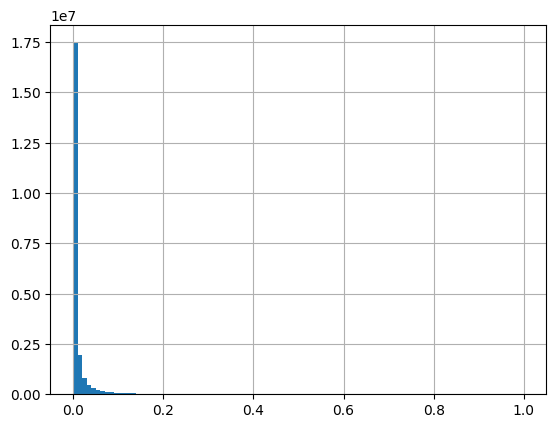

In [3]:
panel_item.share_sales_sku_ma.hist(bins=100)

In [2]:
[col for col in panel_item.columns]

['store_nbr',
 'item_nbr',
 'family',
 'class',
 'perishable',
 'week_start',
 'iso_year',
 'iso_week',
 'sales_sw',
 'promo_days_self_sw',
 'promo_prop_self_sw',
 'total_sales_family',
 'share_sales_sku',
 'share_sales_sku_ma',
 'weighted_promo_self',
 'fam_promo_intensity_all',
 'fam_promo_intensity_ex_self_sw',
 'n_holidays',
 'any_bridge',
 'any_additional',
 'any_event',
 'any_workday',
 'any_holiday',
 'earthquake_window',
 'vat_14',
 'vat_back_12',
 'transactions',
 'oil_price',
 'month',
 'week_of_year',
 'sin_woy',
 'cos_woy',
 'sales_sw_lag1',
 'sales_sw_lag2',
 'sales_sw_lag4',
 'sales_sw_lag8',
 'sales_sw_lag52',
 'fam_promo_intensity_ex_self_sw_lag1',
 'fam_promo_intensity_ex_self_sw_lag2',
 'fam_promo_intensity_ex_self_sw_lag4',
 'fam_promo_intensity_ex_self_sw_lag8',
 'fam_promo_intensity_ex_self_sw_lag52',
 'transactions_lag1',
 'transactions_lag2',
 'transactions_lag4',
 'transactions_lag8',
 'transactions_lag52',
 'oil_price_lag1',
 'oil_price_lag2',
 'oil_price_lag4'

In [2]:
panel_item.head()

,store_nbr,item_nbr,family,class,perishable,week_start,iso_year,iso_week,sales_sw,promo_days_self_sw,...,T,start_run,run_seq,run_len,n_pre_weeks,washout,city,state,type,cluster
0,1,96995,GROCERY I,1093,0,2012-12-31,2013,1,0.0,0.0,...,0,0,NaN,NaN,NaN,0,Quito,Pichincha,D,13
1,1,96995,GROCERY I,1093,0,2013-01-07,2013,2,2.0,0.0,...,0,0,NaN,NaN,NaN,0,Quito,Pichincha,D,13
2,1,96995,GROCERY I,1093,0,2013-01-14,2013,3,3.0,0.0,...,0,0,NaN,NaN,NaN,0,Quito,Pichincha,D,13
3,1,96995,GROCERY I,1093,0,2013-01-21,2013,4,2.0,0.0,...,0,0,NaN,NaN,NaN,0,Quito,Pichincha,D,13
4,1,96995,GROCERY I,1093,0,2013-01-28,2013,5,2.0,0.0,...,0,0,NaN,NaN,NaN,0,Quito,Pichincha,D,13


In [3]:
panel_item.describe()

,store_nbr,item_nbr,class,perishable,iso_year,iso_week,sales_sw,promo_days_self_sw,promo_prop_self_sw,total_sales_family,...,oil_price_lag52,sales_sw_winsor,sales_sw_log1p,T,start_run,run_seq,run_len,n_pre_weeks,washout,cluster
count,4.227377e+07,4.227377e+07,4.227377e+07,4.227377e+07,4.227377e+07,4.227377e+07,4.227377e+07,4.227377e+07,4.227377e+07,2.358233e+07,...,3.319015e+07,4.227377e+07,4.227377e+07,42273770.0,4.227377e+07,0.0,3.753501e+06,2619479.0,42273770.0,4.227377e+07
mean,2.780365e+01,1.216690e+06,2.183585e+03,2.263446e-01,2.014843e+03,2.531405e+01,2.540000e+01,1.847628e-01,2.639469e-02,1.699719e+04,...,7.304435e+01,2.507657e+01,1.722474e+00,0.0,2.345327e-02,NaN,1.516691e+01,0.0,0.0,8.525557e+00
std,1.593813e+01,5.821222e+05,1.508961e+03,4.184647e-01,1.345382e+00,1.482461e+01,8.091946e+01,8.004115e-01,1.143445e-01,1.743743e+04,...,2.662773e+01,7.462896e+01,1.768698e+00,0.0,1.513381e-01,NaN,3.505651e+01,0.0,0.0,4.626512e+00
min,1.000000e+00,9.699500e+04,1.002000e+03,0.000000e+00,2.013000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.814400e+01,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,1.000000e+00,0.0,0.0,1.000000e+00
25%,1.400000e+01,7.899050e+05,1.068000e+03,0.000000e+00,2.014000e+03,1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.728000e+03,...,4.673000e+01,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,3.000000e+00,0.0,0.0,4.000000e+00
50%,2.800000e+01,1.239897e+06,1.386000e+03,0.000000e+00,2.015000e+03,2.500000e+01,4.000000e+00,0.000000e+00,0.000000e+00,1.169000e+04,...,8.170700e+01,4.000000e+00,1.609438e+00,0.0,0.000000e+00,NaN,6.000000e+00,0.0,0.0,9.000000e+00
75%,4.200000e+01,1.695845e+06,3.008000e+03,0.000000e+00,2.016000e+03,3.800000e+01,2.400000e+01,0.000000e+00,0.000000e+00,2.427145e+04,...,9.729000e+01,2.400000e+01,3.218876e+00,0.0,0.000000e+00,NaN,1.300000e+01,0.0,0.0,1.300000e+01
max,5.400000e+01,2.127114e+06,7.780000e+03,1.000000e+00,2.017000e+03,5.300000e+01,8.944000e+04,7.000000e+00,1.000000e+00,2.016370e+05,...,1.087700e+02,1.299983e+04,9.472769e+00,0.0,1.000000e+00,NaN,2.420000e+02,0.0,0.0,1.700000e+01


In [ ]:
panel_item.to_csv("panel_item.csv", index=False)
fam_panel.to_csv("fam_panel.csv", index=False)


In [ ]:
import pandas as pd
panel_item = pd.read_csv("panel_item.csv")
fam_panel= pd.read_csv("fam_panel.csv")